# NYC 311 Service Requests -  Cleaning, EDA, Modeling
### Danielle Medellin [GitHub](https://github.com/dmedellin2)

Using the data collected in the [previous notebook](./1_data_gathering_311.ipynb), we will begin to explore 311 service requests. 

## Data Dictionary

|Feature|Type|Description|
|---|:---:|:---|
|unique_key|int|Unique identifier of a Service Request (SR) in the open data set|
|created_date|datetime|Date and time when SR was submitted|
|closed_date|datetime|Date and time when SR was resolved and closed|
|agency|object|Acronym for agency which responds to the SR|
|agency_name|object|Which agency responds to the SR|
|complaint_type|object|The first level of a hierarchy identifying the topic of the incident or condition. Complaint Type may have a corresponding Descriptor or may stand alone.|
|descriptor|object|Associated to the Complaint Type, and provides further detail on the incident or condition. Descriptor values are dependent on the Complaint Type, and are not always required in SR.|
|location_type|object|Describes the type of location used in the address information|
|status|object|Status of SR at time of data collection. For the purpose of this project, only entries with status 'Closed' were collected|
|borough|object|Name of borough|
|open_data_channel_type|object|Indicates how the SR was submitted to 311.  i.e. By Phone, Online, Mobile, Other or Unknown|
|resolution_description|object|Describes the last action taken on the SR by the responding agency.  May describe next or future steps|
|resolution_action_updated_date|datetime|Date when responding agency last updated SR|
|latitude|float|Latitude in decimal degrees|
|longitude|float|Longitude in decimal degrees|
|waittime|float|Time elapsed from created date to closed date in days|

Data dictionary adapted from [original dataset](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9).  As explained in the `1_data_gathering_311` notebook, we collected data from the 311 NYC Open Data API. In order to better serve our purpose and our model, we decided to search specifically for requests that were already closed, and all requests were responded to by the NYPD. Specific details of each column/feature in the data set can be found above. 

## Table of Contents

- [Import Libraries](#Library-Imports)  
- [Load Data](#Import-Data)  
- [Data Cleaning](#Data-Cleaning)  
    - [Null Values](#Checking-for-null-values)  
    - [Wait Time](#Checking-waittime)  
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Target Variable](#Target-Variable)
    - [Analysis of Features](#Analysis-of-Features)
    - [k-Modes](#k-Modes) 
    - [Time Series](#Time-Series)
- [Model Preparation](#Model-Preparation)
    - [Dummify Columns](#Dummify-Columns)
    - [RMSE Function](#RMSE-Function)
- [Modeling](#Modeling)
    - [Baseline Model](#Baseline-Model)
    - [Linear Regression](#Linear-Regression)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [GLM - Gamma Regression](#Generalized-Linear-Model---Gamma-Regression)
    - [AdaBoost](#AdaBoost)
    - [ARIMA](#ARIMA)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
    - [Predictions and Residuals](#Training-and-Testing-Predictions-and-Residuals)
    - [Interpreting Coefficients](#Interpreting-Coefficients)
    - [Evaluation with Holdout](#Evaluation-Using-Holdout-Set)
- [Pickling](#Pickling)
- [Conclusions & Recommendations](#Conclusions-&-Recommendations)
- [References](#References)

## Library Imports
[Table of Contents](#Table-of-Contents)

In [85]:
# if not already installed
# !pip install kmodes

In [558]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from kmodes.kmodes import KModes
import statsmodels.api as sm 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
import statsmodels.formula.api as smf
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

import pickle
import os

# for reproducibility 
RANDOM_STATE = 11714

## Import Data
[Table of Contents](#Table-of-Contents)

In [4]:
# read in data
original = pd.read_csv('../data/service_request.csv')

### Creating Training and Validation Sets

In [559]:
# split data into training and holdout set
sr, val = train_test_split(original, test_size = .1, random_state = RANDOM_STATE)

In [560]:
# check shape of training set
sr.shape

(540000, 32)

In [561]:
# check shape of holdout set
val.shape

(60000, 32)

In an effort to see how our model works on completely new data, we created a validation (or holdout) set of data. We used only 10% of the data for this validation set, as it is an extra step of measuring our model's success. We will clean this data set in the same ways we clean our training data set, but will not perform any EDA on the validation set.

## Data Cleaning
[Table of Contents](#Table-of-Contents)

In [562]:
sr.shape

(540000, 32)

After splitting our data into a training and holdout set, we have 540,000 observations and 32 features. 

In [563]:
sr.dtypes

unique_key                          int64
created_date                       object
closed_date                        object
agency                             object
agency_name                        object
complaint_type                     object
descriptor                         object
location_type                      object
status                             object
community_board                    object
borough                            object
open_data_channel_type             object
park_facility_name                 object
park_borough                       object
incident_zip                      float64
incident_address                   object
street_name                        object
cross_street_1                     object
cross_street_2                     object
intersection_street_1              object
intersection_street_2              object
city                               object
landmark                           object
bbl                               

As seen above we have many features, some of which will not be helpful to us or we will not use. For example, anything pertaining to a _specific_ address or location will not be used such as `incident_address` or `incident_zip` as these factors can often be indicators of other features such as race or socioeconomic status. Instead, we will simply keep `borough` as it is a large enough bucket with diverse populations. We will keep `longitude` and `latitude` for visualization purposes, but it will not be included in the model itself. Some of the features listed above are repetitive, such as `x_coordinate_state_plane`, as it will serve the same purpose as `latitude`. Features like `cross_street_1` or `intersection_street_1` are not needed for our purposes, as these featuers are usually used to help the responding agency find the source of the request. Since we aren't focusing on exact locations, we will not need these features. 


Two features that are important to us are the `created_date` and `closed_date` columns, which are currently being read as objects. We will convert these to datetime.  

Many of the remaining columns are categorical ones, such as `location_type`, which we expect to have null values for. We will fill all null values for these types of features with either `unknown` or `none` as it still gives us the same information, but will be able to be used in our visuals and models. 

In [564]:
def clean_dataframe(train, holdout):
    for df in [train, holdout]: # clean both dfs at once
        
        df.drop_duplicates(inplace=True) # drop duplicates
        
        # convert columns to datetime
        for col in ['created_date', 'closed_date', 'resolution_action_updated_date']:
            df[col] = pd.to_datetime(df[col])
        
        
        # fill empty descriptions with 'none'
        df['descriptor'].fillna('none', inplace=True)
        
        df['resolution_description'].fillna('none', inplace=True) 
        
        # fill empty location types with unknown
        df['location_type'] = df['location_type'].fillna('unknown')
        
        # drop columns that are repetitive and will not be useful to the model 
        df.drop(columns=['landmark','intersection_street_1','cross_street_1',
                         'cross_street_2','intersection_street_2',
                        'community_board','incident_zip','incident_address',
                        'street_name','bbl','x_coordinate_state_plane',
                        'y_coordinate_state_plane','city','park_borough',
                        'park_facility_name','location'], inplace=True)

The above function will take in both the training and validation set and clean them as discussed above, dropping necessary columns and filling in null values where appropriate. 

In [565]:
# cleaning both dataframes at once
clean_dataframe(sr, val)

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

### Checking for null values
[Table of Contents](#Table-of-Contents)

In [566]:
sr.isnull().sum().sort_values()

unique_key                            0
created_date                          0
closed_date                           0
agency                                0
agency_name                           0
complaint_type                        0
descriptor                            0
location_type                         0
status                                0
borough                               0
open_data_channel_type                0
resolution_description                0
waittime                              0
resolution_action_updated_date      178
latitude                          10978
longitude                         10978
dtype: int64

In [567]:
sr[sr['resolution_action_updated_date'].isnull()]['resolution_description'].value_counts()

Your complaint has been forwarded to the New York Police Department for a non-emergency response. Your complaint will take priority over other non-emergency complaints. 311 will have additional information in 8 hours. Please note your service request number for future reference.                                                                                                                                                                                                                               155
Your complaint has been forwarded to the New York Police Department for a non-emergency response. If the police determine the vehicle is illegally parked, they will ticket the vehicle and then you may either contact a private towing company to remove the vehicle or ask your local precinct to contact 'rotation tow'. Any fees charged for towing will have to be paid by the vehicle owner. 311 will have additional information in 8 hours. Please note your service request number for future refere

The only columns remaining with null values are `longitude`, `latitude`, and `resolution_action_updated_date`. Because we will not be using `longitude` and `latitude` in our model, but just for visualization purposes, we will keep these null values as is. After some exploration, it was shown that requests with a null value for `resolution_action_updated_date` often had a `resolution_description` that informed the civilian that their request was in fact forwarded to the NYPD, non-emergent, and more information would be available within 8 hours. Unfortunately, these were never updated.

### Checking `waittime`
[Table of Contents](#Table-of-Contents)

In [568]:
sr[sr['waittime'] < 0].head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,status,borough,open_data_channel_type,latitude,longitude,resolution_description,resolution_action_updated_date,waittime
180229,44212516,2019-11-03 01:16:04,2019-11-03 01:10:20,NYPD,New York City Police Department,Homeless Encampment,none,Store/Commercial,Closed,MANHATTAN,ONLINE,40.709304,-74.005295,The Police Department responded to the complai...,2019-11-03 06:10:25,-1.996019
180012,44209266,2019-11-03 01:57:58,2019-11-03 01:52:37,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,Closed,BROOKLYN,MOBILE,40.716626,-73.961798,The Police Department responded to the complai...,2019-11-03 06:52:45,-1.996285
180151,44210509,2019-11-03 01:30:57,2019-11-03 01:07:57,NYPD,New York City Police Department,Homeless Encampment,none,Store/Commercial,Closed,MANHATTAN,ONLINE,40.709954,-74.008999,The Police Department responded to the complai...,2019-11-03 06:07:58,-1.984028
180050,44215330,2019-11-03 01:49:02,2019-11-03 01:21:44,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,Closed,QUEENS,PHONE,40.740511,-73.919239,The Police Department responded to the complai...,2019-11-03 06:21:51,-1.981042
180141,44212550,2019-11-03 01:32:28,2019-11-03 01:21:24,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,Closed,QUEENS,ONLINE,40.740511,-73.919239,The Police Department responded to the complai...,2019-11-03 06:21:32,-1.992315


There were 16 observations that had a negative wait time, which doesn't make any sense. After further investigation, it was found that these particular requests were all made on the same day, 2019-11-03, within the 1 am hour. There were varying boroughs and submission types, so no pattern was found there. All complaints were either a noise complaint or related to a homeless encampment. There were other requests made on this day that did not seem to have this error. Being these entries make up less than .01% of the whole dataset, we will simply drop these rows from the training set. We understand that if this same error occurs in the validation set, we will not be able to drop said rows, but are hoping this was a one time error in data collection and that these errors will make up only a small portion of the whole dataset to not affect our predictions too strongly.

In [569]:
# drop negative waittimes 
indices_to_drop = sr[sr['waittime'] < 0].index
sr.drop(index=indices_to_drop, inplace=True)
sr.shape

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(539984, 16)

## Exploratory Data Analysis
[Table of Contents](#Table-of-Contents)

### Target Variable

In [570]:
sr['waittime'].describe()

count    539984.000000
mean          0.442553
std           3.493269
min           0.000197
25%           0.058032
50%           0.133848
75%           0.274436
max         206.016285
Name: waittime, dtype: float64

The average wait time is 0.4426 days, with a standard deviation of 3.493 days. The maximum wait time in this dataset is over 206 days. The 75th percentile, though, is still less than one day at 0.274, showing that longer wait times are unexpected and rarer. 

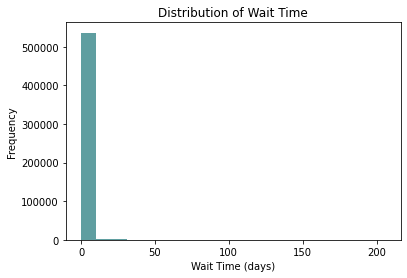

In [573]:
plt.hist((sr['waittime']), color = 'cadetblue', bins=20)
plt.title('Distribution of Wait Time')
plt.xlabel('Wait Time (days)')
plt.ylabel('Frequency');

It is clear that the overwhelming majority of the data is close to 0 and more specifically, is less than about 10. There is a slight right skew showing some values between 0 and 50, and while not noticable on the graph itself, there are wait times of over 200 days. Due to these outliers we will set a limit on our target variable, wait time.

In [574]:
low_sr = sr[sr['waittime'] <= 31]

In [629]:
low_sr.shape

(539312, 16)

Our training set now has 539,312 values, losing only .13% of the initial training set. 

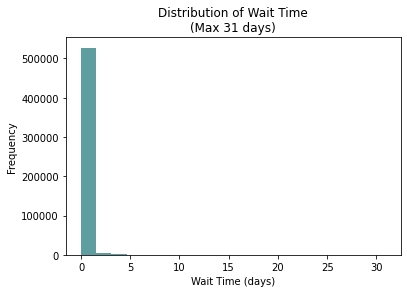

In [576]:
plt.hist((low_sr['waittime']), color = 'cadetblue', bins=20)
plt.title('Distribution of Wait Time\n(Max 31 days)')
plt.xlabel('Wait Time (days)')
plt.ylabel('Frequency');

We have decided to limit the wait time variable at 1 month or 31 days, as any request taking longer than a month to resolve likely has additional conditions surrounding it. Still, though, the ditribution of data is heavily on the left side of the graph with a slight right skew showing some values for wait time between 1 and 5 days. 

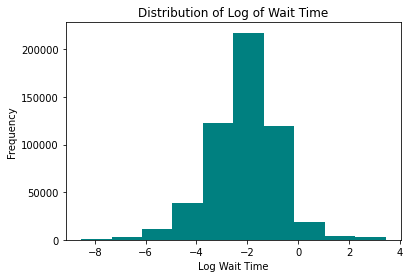

In [577]:
plt.hist(np.log(low_sr['waittime']), color = 'teal')
plt.title('Distribution of Log of Wait Time')
plt.xlabel('Log Wait Time')
plt.ylabel('Frequency');

When looking at the distribution of wait time, the original distribution was very skewed, due to the large but rare wait times discussed previously. In order to have a target variable that is closer to being normally distributed, we took the log of the wait times. In our model, we will use the log of our target variable. 

### Analysis of Features
[Table of Contents](#Table-of-Contents)

In [9]:
def plot_pct_waittime(y, pct_width, avg_width, colors, y_label):
    """
    Plots 2 horizontal bar charts, the first showing the percentage breakdown of each category in feature. The second showing the average wait time for each category.
    
    Parameters:
    y: labels for y axis
    pct_width: values for percentage break down
    avg_width: values for wait time averages
    colors: takes list of colors (min 2)
    y_label: y label for graphs
    """
    
    fig, axes = plt.subplots(figsize=(14,5), ncols=2)

    axes[0].set_title(f'Percentage of Most Frequent {y_label}s',size=16)
    axes[0].barh(y=y, width=pct_width, color=colors[0])
    axes[0].set_ylabel(y_label,size=13)
    axes[0].set_xlabel('Percentage',size=13)
    
    axes[1].set_title(f'Average Wait Time (Days) by {y_label}',size=16)
    axes[1].barh(y=y, width=avg_width, color=colors[1])
    axes[1].set_ylabel(y_label,size=13)
    axes[1].set_xlabel('Average Wait Time (Days)',size=13)
    
    fig.tight_layout();
    

The above function will create two graphs for each feature column. The first graph shows a percentage breakdown of that particular feature. The second graph will show the average wait time for each of those responses within a feature. 

In [578]:
low_sr['complaint_type'].value_counts(normalize=True)

Noise - Residential            0.267279
Illegal Parking                0.239761
Blocked Driveway               0.158639
Noise - Street/Sidewalk        0.128955
Noise - Vehicle                0.050553
Abandoned Vehicle              0.046009
Noise - Commercial             0.042845
Non-Emergency Police Matter    0.012442
Homeless Encampment            0.010152
Animal-Abuse                   0.008205
Vending                        0.005998
Traffic                        0.005359
Noise - Park                   0.004969
Panhandling                    0.003822
Drug Activity                  0.003632
Derelict Vehicle               0.002709
Drinking                       0.002208
Illegal Fireworks              0.001517
Bike/Roller/Skate Chronic      0.000884
Graffiti                       0.000879
Homeless Street Condition      0.000868
Noise - House of Worship       0.000825
Urinating in Public            0.000769
Animal Abuse                   0.000488
Disorderly Youth               0.000117


The top two complaint types for these service requests were **_Noise - Residential_** (26.7%) and **_Illegal Parking_** (23.9%), together making up more than half of the complaints. The next two most frequent complaints were **_Blocked Driveway_** (15.9%) and **_Noise - Street/Sidewalk_** (12.9%). Each of the remainder of the complaint types make up about 5% or less per complaint type. Of the 27 different complaint types, 6 were associated with some type of noise complaint.

In [579]:
# pulling top 10 most frequent complaints
top_10_complaints = low_sr['complaint_type'].value_counts(normalize=True)[:10].index
complaint_mean_waittimes = low_sr.groupby('complaint_type')['waittime'].mean()

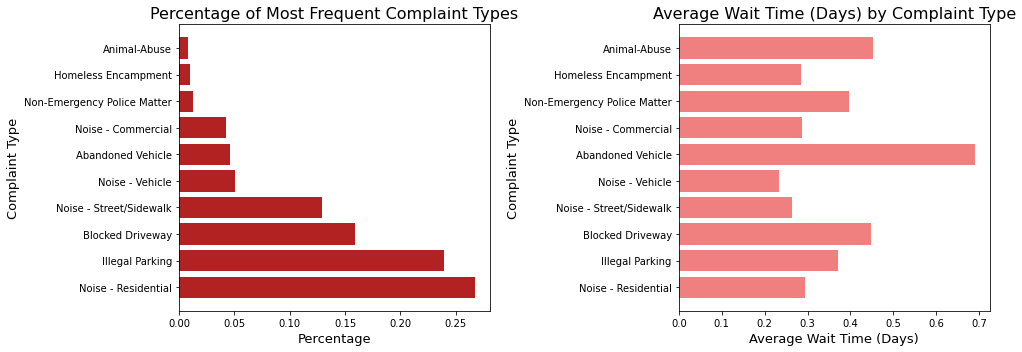

In [580]:
plot_pct_waittime(top_10_complaints,
                  low_sr['complaint_type'].value_counts(normalize=True)[:10],
                  complaint_mean_waittimes[top_10_complaints],
                  ['firebrick','lightcoral'],
                  'Complaint Type')

**Note:** the complaint types are listed in ascending order, where **_Noise - Residential_** is the most frequent complaint type. The top 3 most frequent complaint types had average wait times between roungly 0.3 and 0.5 days. None of the top 10 most frequent complaint types had an average wait time of more than a day. Out of the top 10 most frequent complaint types, the one with the highest average wait time was _**Abandoned Vehicle**_ with just under 0.7 days.

In [584]:
# get percetange  and average waittime for boroughs
borough_counts = low_sr['borough'].value_counts(normalize=True)[:5]
borough_mean = low_sr.groupby('borough')['waittime'].mean()[:5]

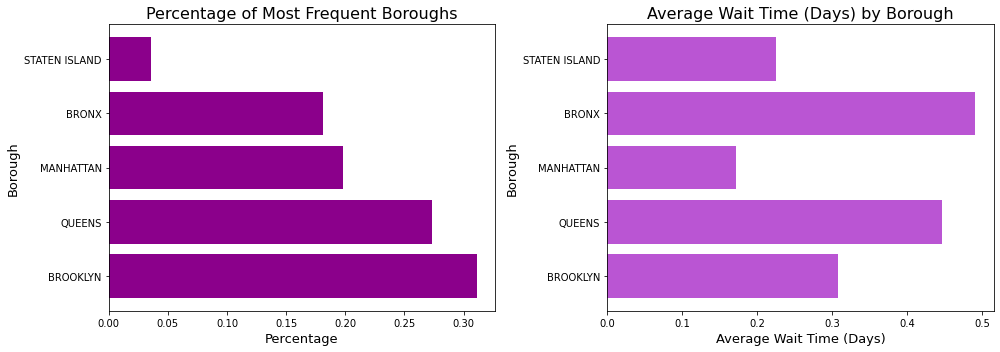

In [585]:
plot_pct_waittime(borough_counts.index,
                  borough_counts,
                  borough_mean[borough_counts.index],
                  ['darkmagenta','mediumorchid'],
                  'Borough')

*Note: Unspecified is another option for `borough` but made up less than 1% of the data so it is not included in this graph.*   
The most service requests came from Brooklyn, followed closely by Queens. The borough with the least amount of service requests was Staten Island. Bronx had the highest average wait time with roughly 0.5 days, followed by Queens with 0.45 days. Manhattan had the lowest average wait time of 0.17 days. All boroughs had an average wait time of 0.5 days or less. 

In [593]:
submission_types = low_sr['open_data_channel_type'].value_counts(normalize=True)[:3]
submission_means = low_sr.groupby('open_data_channel_type')['waittime'].mean()

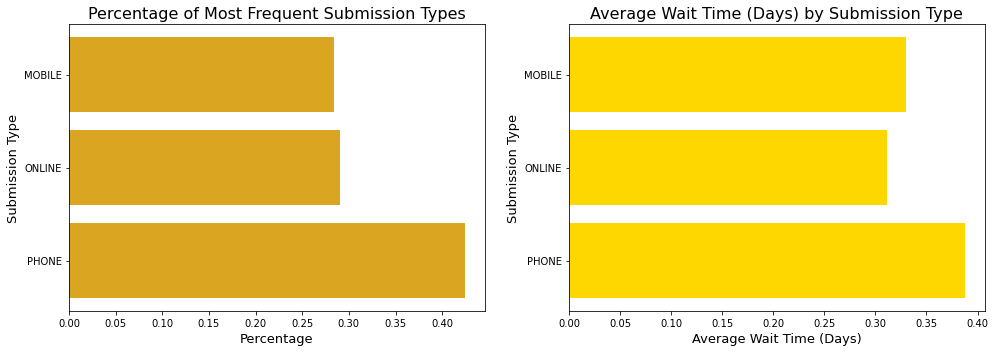

In [592]:
plot_pct_waittime(submission_types.index,
                  submission_types,
                  submission_means[submission_types.index],
                  ['goldenrod','gold'],
                  'Submission Type')

_**Note**: Two other options for `open_data_channel_type` included **UNKNOWN** and **OTHER**, but both made up less than .01% of the data and have been omitted from these graphs._  

Of the three different ways a civilian could submit a service request, **PHONE** was the most popular. Both **ONLINE** and **MOBILE** made up just under 30% of the data each. **PHONE** requests also had the highest average wait time by about 0.1 days difference. 

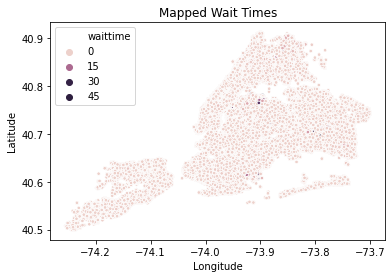

In [594]:
sns.scatterplot(data = low_sr, y='latitude', x = 'longitude', s=12,hue = 'waittime')
plt.title('Mapped Wait Times')
plt.ylabel('Latitude')
plt.xlabel('Longitude');

Above we've mapped each of the service requests with an available longitude and latitue as well as indicated their associated wait time with color hue. The map is fairly consistent, showing that where a request is coming from is not a strong indicator of how long it will take to fulfill that request. There are a few darker spots on the map showing higher wait times, but those are considered outliers when compared to the rest of the data.

### k-Modes

[Table of Contents](#Table-of-Contents)

By using $k$-modes, we are attempting to identify clusters of data that share similarities in their features. Since all of our features are categorical, the mode of each cluster will represent the cluster (as opposed to the mean in $k$-Means). 

In [596]:
# set up X, y
features=['complaint_type','descriptor','location_type','borough','open_data_channel_type']
exog = low_sr[features]
endog = low_sr['waittime']

In [432]:
# source: https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering

cost = [] # empty list for cost values
for num_clusters in list(range(2,9)): # testing n_clusters 2 - 8
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(exog)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 47293, cost: 1410607.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 48722, cost: 1252578.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 78133, cost: 1120849.0
Run 1, iteration: 2/100, moves: 29073, cost: 1120849.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 78421, cost: 1067315.0
Run 1, iteration: 2/100, moves: 27864, cost: 1067315.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 33175, cost: 1072529.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1020319.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 

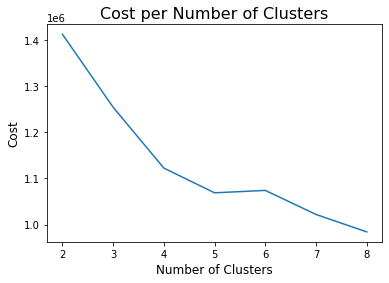

In [287]:
q = np.array([i for i in range(2,9,1)])
plt.plot(q,cost)
plt.ylabel('Cost', size=12)
plt.xlabel('Number of Clusters',size=12)
plt.title('Cost per Number of Clusters',size=16);

In order to choose our $k$ value, we looked to minimize the cost function. We tested values of $k$ from 2 - 8 to see which gave us the best cost value. Those results are shown above. Since the cost value does not decrease, but instead almost levels out between 5 and 6 clusters, we will use 5 as our cluster value for our $k$-Modes model.  

In [601]:
# running our k-Modes model with k = 5
km_cao = KModes(n_clusters=5, init = "Cao", verbose=1)
# creating cluster predictions
fitclusters_cao = km_cao.fit_predict(exog)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 78421, cost: 1067315.0
Run 1, iteration: 2/100, moves: 27864, cost: 1067315.0


In [602]:
# setting up data frames to add predicted clusters from k-modes
sr_ = low_sr.copy().reset_index()
clusters_df = pd.DataFrame(fitclusters_cao)
clusters_df.columns = ['cluster_predicted']

In [603]:
# creating new data frame with cluster predictions data
new_sr = pd.concat([sr_, clusters_df], axis=1).reset_index()
new_sr.drop(columns=['level_0'],inplace=True)

In [604]:
km_cao.cluster_centroids_

array([['Noise - Street/Sidewalk', 'Loud Music/Party', 'Street/Sidewalk',
        'BROOKLYN', 'PHONE'],
       ['Noise - Residential', 'Loud Music/Party',
        'Residential Building/House', 'QUEENS', 'ONLINE'],
       ['Illegal Parking', 'Posted Parking Sign Violation',
        'Street/Sidewalk', 'QUEENS', 'MOBILE'],
       ['Blocked Driveway', 'No Access', 'Street/Sidewalk', 'QUEENS',
        'PHONE'],
       ['Illegal Parking', 'Blocked Hydrant', 'Street/Sidewalk',
        'MANHATTAN', 'PHONE']], dtype='<U29')

The 5 clusters below were created from our $k$-modes model with features listed in this order:  
_Features: `complaint_type`, `descriptor`, `location_type`, `borough`, `open_data_channel_type`_

0. 'Noise - Street/Sidewalk', 'Loud Music/Party', 'Street/Sidewalk', 'BROOKLYN', 'PHONE',
1. 'Noise - Residential', 'Loud Music/Party', 'Residential Building/House', 'QUEENS', 'ONLINE'
2. 'Illegal Parking', 'Posted Parking Sign Violation', 'Street/Sidewalk', 'QUEENS', 'MOBILE'
3. 'Blocked Driveway', 'No Access', 'Street/Sidewalk', 'QUEENS', 'PHONE'
4. 'Illegal Parking', 'Blocked Hydrant', 'Street/Sidewalk','MANHATTAN', 'PHONE'

While every observation in each cluster will not match these results exactly, these requests were found to be most similar to one another. 

Cluster 0 seems to focus on noise complaints made by phone that occur on the sidewalk or street, mainly in Brooklyn. We will rename this cluster `Noise Brooklyn`.

Cluster 1 focuses on noise complaints made online that occur in a residential building or house, mostly in Queens. We will rename this cluster `Noise Queens`.

Cluster 2 focuses on requests about illegal parking involving parking sign violations mostly in Queens, made via mobile. We will rename this cluster `Parking Queens`. 

Cluster 3 focuses on blocked driveways mostly in Queens, made via phone. We will rename this cluster `Driveway Queens`. 

Cluster 4 focuses on requests about illegal parking involving blocked fire hydrants, mostly in Manhattan and made via phone. We will rename this cluster `Parking Manhattan`. 


In [605]:
# renaming 'cluster_predicted' values 
# dictionary with new cluster names
cluster_names = {
    0: 'Noise Brooklyn',
    1: 'Noise Queens',
    2: 'Parking Queens',
    3: 'Driveway Queens',
    4: 'Parking Manhattan'
}

# mapping new cluster names to 'cluster_predicted' column
new_sr['cluster_predicted'] = new_sr['cluster_predicted'].map(cluster_names)
clusters = new_sr['cluster_predicted'].value_counts(normalize=True)

In [606]:
# finding average wait time for each cluster 
cluster_means = new_sr.groupby('cluster_predicted')['waittime'].mean()
cluster_means

cluster_predicted
Driveway Queens      0.464547
Noise Brooklyn       0.318649
Noise Queens         0.307245
Parking Manhattan    0.261207
Parking Queens       0.400366
Name: waittime, dtype: float64

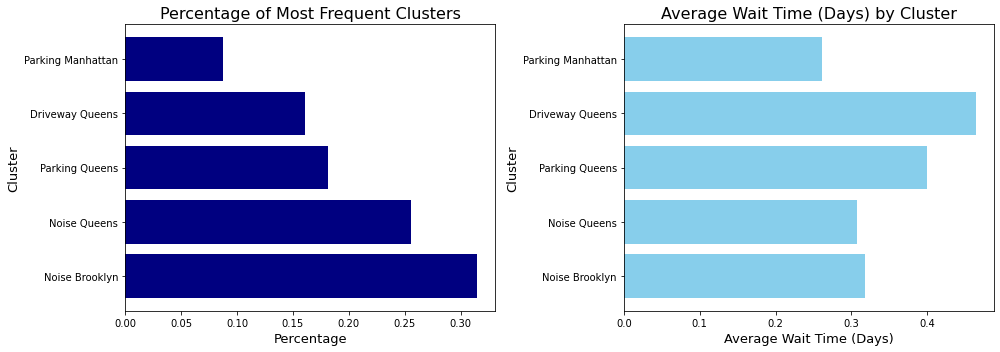

In [607]:
plot_pct_waittime(clusters.index,
                  clusters,
                  cluster_means[clusters.index],
                  ['navy','skyblue'],
                  'Cluster')

Three of the 5 clusters were focused in Queens, the second most frequent borough overall. The cluster with the most observations was the `Noise Brooklyn` cluster, while the cluster with the least amount of observations  was the `Parking Manhattan` cluster. Both the Bronx and Staten Island were not considered a centroid for any cluster. They were the two least common boroughs in the data set. Two of the three clusters related to _Queens_ had the highest average wait times. The third (`Noise Queens`) had a very similar average wait time to the `Noise Brooklyn` cluster. The `Driveway Queens` cluster had the highest average wait time of about 0.5 days. The cluster with the lowest average wait time was the `Parking Manhattan` cluster with about .26 days.

### Time Series
[Table of Contents](#Table-of-Contents)

Features we have not explored yet are those related to date/time. In the following cells, we will see if there are any patterns relating the time a service request was created to the amount of time it takes to complete the request.  

_**Note**: we are not using the same training and holdout set as above, being that the data must be sequential. We will start with the original data set and use the last 20% of data as our holdout set._

In [410]:
# creating a data frame to evaluate using time series
ts_df = original[['created_date','waittime']]
# set to date time
ts_df['created_date'] = pd.to_datetime(ts_df['created_date'])

# set the date as an index
ts_df.set_index('created_date', inplace=True)

# sort index
ts_df.sort_index(inplace=True, ascending=True)
ts_df.head()

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,waittime
created_date,
2019-05-28 04:53:17,0.078715
2019-05-28 04:53:50,0.094618
2019-05-28 04:54:00,0.135891
2019-05-28 04:58:44,0.010903
2019-05-28 05:00:34,0.068704


Our data is currently at random time intervals based on when the request was created. We will use `resample` to consolidate some of this data. 

In [608]:
# resampling by day
ts_df = ts_df.resample('D').mean()
ts_df.head()

,waittime
created_date,
2019-05-28,0.176304
2019-05-29,0.194450
2019-05-30,0.212966
2019-05-31,0.196698
2019-06-01,0.329444


In [609]:
ts_df.shape

(249, 1)

After resampling, we have one average wait time for each day in our data set, which leaves us with 249 observations. 

In [610]:
# train test split 
t_train, t_test = train_test_split(ts_df, test_size=.2, shuffle=False)

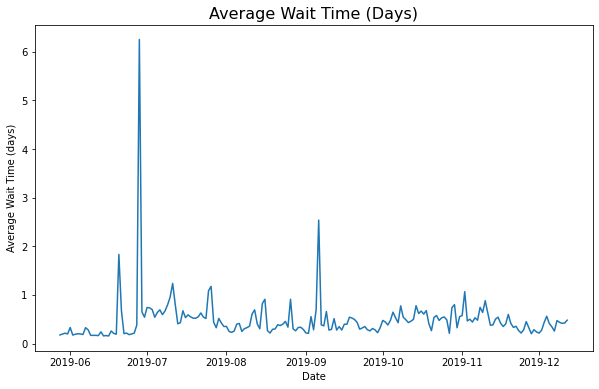

In [614]:
# Generate line plot of wait time
plt.figure(figsize=(10,6))
plt.plot(t_train['waittime']);
plt.title(label='Average Wait Time (Days)', fontsize = 16)
plt.xlabel("Date")
plt.ylabel("Average Wait Time (days)");

Overall, there seems to be consistency in the wait time over time. We see a few spikes in the data. The first major spike comes in late June 2019. After some deeper investigation is appears that on June 28, 2019 there was a much higher average wait time for service requests. No research led us to a definitive answer of why this could have occurred. 

The second large spike came in the first week or so of September 2019. Again, there was no clear evidence as to why this spike might have occurred at this time.

## Model Preparation
[Table of Contents](#Table-of-Contents)

### Dummify Columns

The features we will include in our model are `complaint_type`, `descriptor`, `location_type`, `borough`, `open_data_channel_type`, and `cluster_predicted`. All of these columns are categorical and will need to be dummified. 

In [615]:
# features to go into models 
new_features = ['complaint_type',
 'descriptor',
 'location_type',
 'borough',
 'open_data_channel_type', 'cluster_predicted']

In [617]:
dummy_sr = new_sr[new_features]
dummy_sr = pd.get_dummies(dummy_sr, columns=new_features, drop_first=True)

In [618]:
# set up X and y
X = dummy_sr
y = new_sr['waittime']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

For our models, X are the dummified columns of `new_features` and y is our target variable, `waittime`.

#### RMSE Function
[Table of Contents](#Table-of-Contents)

The metric we will use to measure the success of our models will be root mean squared error (RMSE). The functions below will calculate the RMSE using the actual values and the predicted values from our model. Because some of our models will use the log of the target variable, we have created an additional function that will handle this situation.

In [619]:
# source: Mahdi Shadkam-Farrokhi, https://git.generalassemb.ly/DSI-US-11/local_faq/blob/master/code/custom_cross_val_score.ipynb

# function to find RMSE 
def rmse(y_true, y_pred): # this signature matters for later use with `make_scorer`
    '''Returns the root mean squared error'''
    return np.sqrt(mean_squared_error(y_true, y_pred))


def rmse_log(y_true, y_pred): # this signature matters for later use with `make_scorer`
    '''Returns the root mean squared error when the target is log(y)'''
    return np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred)))

## Modeling 
[Table of Contents](#Table-of-Contents)

We will be using root mean squared error (RMSE) as our metric to measure the success of our models. Reminder that a smaller RMSE indicates a "better" model as there is less error. 

### Baseline Model

In [620]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dummy_tr_preds = dummy.predict(X_train) 
dummy_te_preds = dummy.predict(X_test)

In [621]:
print(f'Train:', rmse(y_train, dummy_tr_preds))
print(f'Test:', rmse(y_test, dummy_te_preds))
print(f'Cross Val:', cross_val_score(dummy, X, y, scoring=make_scorer(rmse), cv=5).mean())
print(f'Difference: {rmse(y_test, dummy_te_preds) - rmse(y_train, dummy_tr_preds)}')

Train: 1.4746198199844749
Test: 1.4359782004542598
Cross Val: 1.464729948471881
Difference: -0.038641619530215054


Our simplest model is performing with a testing RMSE of 1.44 days. Being that the overwhelming majority of our data target variable was less than 1 day, this is showing a fairly large margin of error. Additionally, the training score (1.47) is higher than the testing score indicating our model is currently underfit. 

### Linear Regression
[Table of Contents](#Table-of-Contents)

Because the distribution of our target variable is so heavily skewed, we will be using the log of the target variable as its distribution is much closer to a normal distribution. 

In [48]:
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))
lr_tr_preds = lr.predict(X_train)
lr_te_preds = lr.predict(X_test)

In [622]:
print(f'Train:', rmse(y_train, np.exp(lr_tr_preds)))
print(f'Test:', rmse(y_test, np.exp(lr_te_preds)))
print(f'Cross Val:', cross_val_score(lr, X, np.log(y), scoring=make_scorer(rmse_log), cv=5).mean())
print(f'Difference: {rmse(y_test, np.exp(lr_te_preds)) - rmse(y_train, np.exp(lr_tr_preds))}')

Train: 1.4877216610143758
Test: 1.448758512608645
Cross Val: 1.4777801265938266
Difference: -0.038963148405730674


Our linear regression model is performing at essentially the same level as our baseline model. The training (1.49) and testing (1.45) scores are very close to the baseline scores with a similar difference in the scores (-.039), again showing an underfit model. We will continue with a different model approach. 

### Decision Tree
[Table of Contents](#Table-of-Contents)

In [82]:
tree = DecisionTreeRegressor()

# construct paramters
tree_params = {
    'max_depth' : [3],
    'max_features' : [7],
    'min_samples_leaf' : [3]
}

 # Perform Grid Search
gs = GridSearchCV(tree, 
                 param_grid=tree_params,
                 cv = 5,
                 scoring = make_scorer(rmse))
tree = gs.fit(X_train, y_train)

In [83]:
tree.best_params_

{'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 3}

In [84]:
tree_tr_preds = tree.predict(X_train)
tree_te_preds = tree.predict(X_test)

In [85]:
print(f'Train:', rmse(y_train, tree_tr_preds))
print(f'Test:', rmse(y_test, tree_te_preds))
print(f'Cross Val:', cross_val_score(tree.best_estimator_, X, y, scoring=make_scorer(rmse), cv=5).mean())
print(f'Difference: {rmse(y_test, tree_te_preds) - rmse(y_train, tree_tr_preds)}')

Train: 1.4734682305010258
Test: 1.4348725487288598
Cross Val: 1.463273847194364
Difference: -0.03859568177216599


Again, our decision tree model is showing similar results to the previous models. Training RMSE is 1.47, testing RMSE is 1.43, and the difference between the scores is -0.039. Our model continues to be underfit, but we will try using a random forest model in an attempt to add randomness to our model and hopefully improve our RMSE. 

### Random Forest
[Table of Contents](#Table-of-Contents)

In [104]:
rf = RandomForestRegressor()

# construct paramters
rf_params = {
    'n_estimators' : [80],
    'max_features' : [20],
    'max_depth' : [3]
}

 # Perform Grid Search
gs = GridSearchCV(rf, 
                 param_grid=rf_params,
                 cv = 5,
                 scoring = make_scorer(rmse))
rf = gs.fit(X_train, y_train)

In [105]:
rf.best_params_

{'max_depth': 3, 'max_features': 20, 'n_estimators': 80}

In [106]:
rf_tr_preds = rf.predict(X_train)
rf_te_preds = rf.predict(X_test)

In [107]:
print(f'Train:', rmse(y_train, rf_tr_preds))
print(f'Test:', rmse(y_test, rf_te_preds))
print(f'Cross Val:', cross_val_score(rf.best_estimator_, X, y, scoring=make_scorer(rmse), cv=5).mean())
print(f'Difference: {rmse(y_test, rf_te_preds) - rmse(y_train, rf_tr_preds)}')

Train: 1.4696320267085226
Test: 1.4310856630732955
Cross Val: 1.460245274720122
Difference: -0.03854636363522701


While the random forest model is showing small differences from the previous models, our training and testing scores are essentially the same as before. Training RMSE remains at 1.47, testing RMSE is 1.43 and the difference is still -0.039.

### Generalized Linear Model - Gamma Regression
[Table of Contents](#Table-of-Contents)

A generalized linear model using Gamma regression is useful when we are attempting to predict the time until an event occurs. In this instance, the event is the service requet being closed, so we are predicting how long it will take for the request to be closed.  

In [108]:
train_index = X_train.index
test_index = X_test.index

In [109]:
r_sr = new_sr[new_features + ['waittime']]
r_train = r_sr.iloc[train_index]
r_test = r_sr.iloc[test_index]

We use `statsmodels` to run our GLM and will be using a custom formula. Our data needs to be in the same dataframe, not split up into X and y for these models. 

In [115]:
glm_gamma_log = smf.glm(
    formula = "waittime ~ C(complaint_type) + C(descriptor) + C(location_type) + C(borough) + C(open_data_channel_type) + C(cluster_predicted)",
    data = r_train,
    family = sm.families.Gamma(link = sm.families.links.log)
).fit()

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  after removing the cwd from sys.path.


In [118]:
gamma_log_tr_preds = glm_gamma_log.predict(r_train)
gamma_log_te_preds = glm_gamma_log.predict(r_test)

In [119]:
print(f'Train:', rmse(y_train, gamma_log_tr_preds))
print(f'Test:', rmse(y_test, gamma_log_te_preds))
print(f'Difference: {rmse(y_test, gamma_log_te_preds) - rmse(y_train, gamma_log_tr_preds)}')

Train: 1.4670255226021836
Test: 1.4288278081866703
Difference: -0.03819771441551323


Again we see a small decrease in the scores, but when rounded match the previously recorded scores. Training RMSE remains 1.47, testing RMSE is 1.43, and the difference is -0.038. Due to the fact that our model is still underfit, we will lastly try an AdaBoost model which should help with the increased bias in our current models. 

### AdaBoost
[Table of Contents](#Table-of-Contents)

In [134]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
ada_params = {
    'n_estimators': [100],
    'base_estimator__max_depth': [2],
    'learning_rate': [1.]
}
gs = GridSearchCV(ada, param_grid=ada_params, cv=5)
ada = gs.fit(X_train, y_train)

In [135]:
ada.best_params_

{'base_estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 100}

In [136]:
ada_tr_preds = ada.predict(X_train)
ada_te_preds = ada.predict(X_test)

In [137]:
print(f'Train:', rmse(y_train, ada_tr_preds))
print(f'Test:', rmse(y_test, ada_te_preds))
print(f'Difference: {rmse(y_test, ada_te_preds) - rmse(y_train, ada_tr_preds)}')

Train: 1.4706017425911349
Test: 1.4318082632031572
Difference: -0.038793479387977614


Despite our beliefs that the AdaBoost model would address the underfitting issue, it did not. Our training and testing scores remain the same as stated above. 

### ARIMA
[Table of Contents](#Table-of-Contents)  

We looked into a time series model to see if the `created_date` would be a good predictor of our target variable, `waittime`. 

In [371]:
def interpret_dftest(target_column):
    '''Returns the Test Statistic and p-value for Augmented Dickey-Fuller test on given target column'''
    dftest = adfuller(target_column)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [414]:
interpret_dftest(t_train['waittime'])

Test Statistic   -1.246683e+01
p-value           3.311299e-23
dtype: float64

Using the augmented Dickey-Fuller test on our target column, we got a p-value of 3.311299e-23. Since p is less than alpha (0.05), we can reject the null hypothesis and state that our target column has stationarity. 

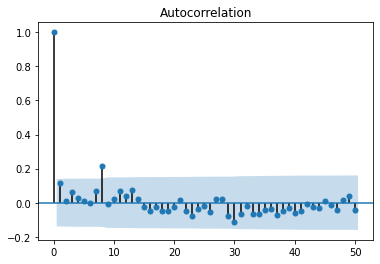

In [415]:
plot_acf(t_train['waittime'], lags = 50);

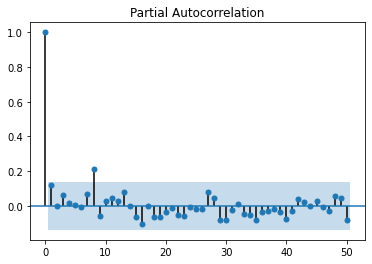

In [416]:
plot_pacf(t_train['waittime'], lags = 50);

Looking at the partial autocorrelation plot of the first 50 lags, the only lags that has a significant correlation with the target variable is lag 8.

In [376]:
from pmdarima import auto_arima

In [417]:
fitted_arima = auto_arima(
    t_train,
    start_p = 0,
    start_q = 0,
    max_p = 2,
    max_q = 2,
    d = 0,
    stationary = True,
    seasonal = False,
    solver = 'lbfgs',
    trace=True,
    error_action='ignore',
    suppress_warnings = True
)

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=285.789, BIC=292.376, Time=0.049 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=285.080, BIC=294.960, Time=0.031 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=285.074, BIC=294.954, Time=0.049 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=419.176, BIC=422.470, Time=0.017 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=287.082, BIC=300.255, Time=0.075 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=287.074, BIC=300.247, Time=0.102 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=287.685, BIC=304.152, Time=0.440 seconds
Total fit time: 0.767 seconds


In [418]:
fitted_arima.order

(0, 0, 1)

The order with the lowest AIC was (0, 0, 1), which is essentially an MA(1) model. This makes sense given what our data looked like earlier. There was stationarity which indicated that d=0, and we noted sudden spikes in the data which is being accounted for with q=1. 

In [419]:
order = (0, 0, 1)
# instatiate
waittime_arima = ARIMA(t_train, order = order, freq = 'D')

#fit
fitted_waittime_arima = waittime_arima.fit()

In [420]:
fitted_waittime_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               waittime   No. Observations:                  199
Model:                     ARMA(0, 1)   Log Likelihood                -139.537
Method:                       css-mle   S.D. of innovations              0.488
Date:                Wed, 03 Jun 2020   AIC                            285.074
Time:                        20:00:42   BIC                            294.954
Sample:                    05-28-2019   HQIC                           289.073
                         - 12-12-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4847      0.039     12.554      0.000       0.409       0.560
ma.L1.waittime     0.1171      0.071      1.655      0.098      -0.022       0.256
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -8.5400           +0.0000j            8.5400            0.5000
-----------------------------------------------------------------------------
"""

In [421]:
arima_tr_preds = fitted_waittime_arima.predict(start=1, end=-1, dynamic=False, typ='levels')

In [424]:
# source: https://git.generalassemb.ly/DSI-US-11/local_arima

# multi step out of sample forecasting 

order = (0,0,1)

temp_test_preds = []
history = t_train.values
conf_ints = []
for value in t_test.values:
    # create model
    arima = ARIMA(history, order = order)
    # fit
    fitted_arima = arima.fit()
    # make next out-of-sample prediction
    pred, _, conf_int = fitted_arima.forecast(steps = 1)
    
    # add to preds and conf_ints
    temp_test_preds.append(pred[0])
    conf_ints.append(conf_int[0])
    
    # add TRUTH to history for next training
    history = np.append(history, value)

In [425]:
new_test_preds = pd.Series(temp_test_preds, index = t_test.index)

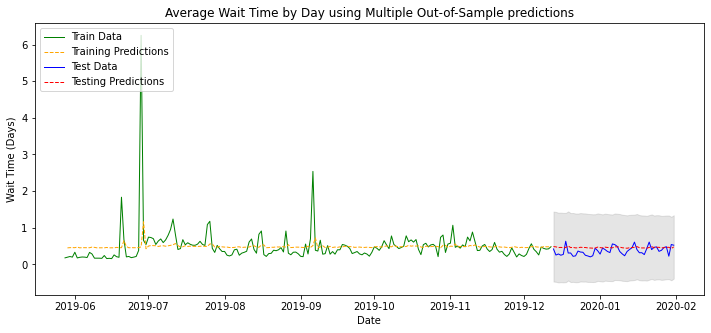

In [623]:
upper_conf_int = np.array(conf_ints)[:,1]
lower_conf_int = np.array(conf_ints)[:,0]

plt.figure(figsize=(12,5))
plt.title("Average Wait Time by Day using Multiple Out-of-Sample predictions")

# train data
plt.plot(t_train.index, t_train, lw=1, color='green', ls='solid',label='Train Data')

# train prediction
plt.plot(arima_tr_preds.index, arima_tr_preds, lw=1, color='orange', ls='dashed',label='Training Predictions')

# test data
plt.plot(t_test.index, t_test, lw=1, color='blue', ls='solid',label='Test Data')

# test predictions
plt.plot(new_test_preds.index, new_test_preds, lw=1, color='red', ls='dashed',label='Testing Predictions')

#  data
plt.xlabel("Date")
plt.ylabel("Wait Time (Days)")

# conf-int
plt.fill_between(t_test.index, lower_conf_int, upper_conf_int, color='k', alpha=0.1);
plt.legend(loc = "upper left");

The predictions for our testing data are not as inconsistent as the true data, but still follow closely to the actual pattern of the data. The predictions fall well within the confidence interval. It is unclear that if there was another sudden spike in the testing portion, if the model would have predicted those spikes. 

In [428]:
rmse(t_train[1:], arima_tr_preds)

0.48857856896853213

In [429]:
rmse(t_test, new_test_preds)

0.14127651355402185

For our ARIMA model the training RMSE score was 0.49 days while the testing RMSE score was 0.14. Being the testing data is performing better than the training data, this model is underfit. These scores are much better than the scores of the previous model, but it's important to note that this model is not measuring `waittime` in the same way. Here we are predicting the average wait time by whole days using only the `created_date` column as our feature. We have lost much of the data due to resampling. 

## Model Selection
[Table of Contents](#Table-of-Contents)

The training and testing RMSE for each model are listed below, as well as the difference between those scores. 

|Model|Training RMSE|Testing RMSE|Difference (Test - Train)|
|:---|:---:|:---:|:---:|
|Baseline|1.47|1.44|-0.039|
|Linear Regression|1.49|1.45|-0.039|
|Decision Tree|1.47|1.43|-0.039|
|Random Forest|1.47|1.43|-0.039|
|GLM - Gamma|1.47|1.43|-0.038|
|AdaBoost|1.47|1.43|-0.039|
|ARIMA|0.49|0.14|-0.35|

As can be seen above, all of the models we tried to use performed essentially the same, besides the ARIMA model. This leads us to believe that the issue lies with the _features_ of our models. Our features are not good predictors of the target variable, wait time for service requests to be closed. The performance of the ARIMA model indicates to us that `created_date` is potentially a better feature to help predict `waittime`. Because of time restrictions, we did not explore the time series model further. 

For the sake of following this problem through to the end, we will select the GLM Gamma regression model as our "best" model. While this model had training and testing scores that were very similar to others, it will allow us to take a deeper dive into how exactly the features we used were affecting the model. It is important to emphasize that the predictions that will come from this model are _not_ good predictions.  

## Model Evaluation
[Table of Contents](#Table-of-Contents)
### Training and Testing Predictions and Residuals

In [161]:
# create residuals
train_resids = y_train - gamma_log_tr_preds
test_resids = y_test - gamma_log_te_preds

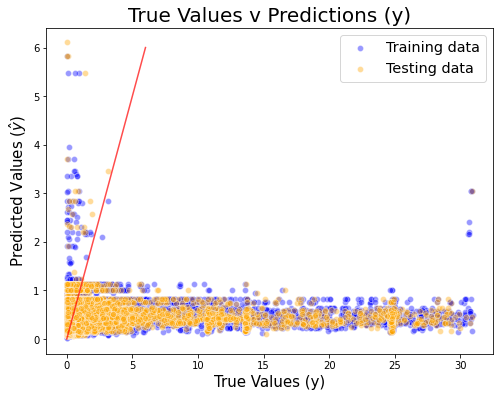

In [295]:
plt.figure(figsize=(8,6))
sns.scatterplot(y_train, gamma_log_tr_preds, label='Training data',color='blue', alpha=.4)
sns.scatterplot(y_test, gamma_log_te_preds, label='Testing data', color='orange',alpha=.4)
plt.xlabel('True Values (y)',size=15)
plt.ylabel('Predicted Values ($\hat{y}$)',size=15)
plt.title('True Values v Predictions (y)',size=20)
plt.legend(loc='upper right',fontsize='x-large')

plt.plot((0,6),(0,6), c = "r", alpha = .7);

If the predictions for the data were accurate or close to accurate, the data would look more _linear_ in nature, similar to the red line show on the graph. The distribution of data we see here shows many observations in the training set that were predicted to be between 1 and 4, while their true value was closer to 0. For both the training and testing data sets, we see that there are many observations with true values spanning from 0 to 30, while their predicted values were from 0 to 1. It is clear that this model is not performing well. The model is overwhelmingly under predicting the actual values, which makes sense given the majority of the data we saw was below 1 day. 

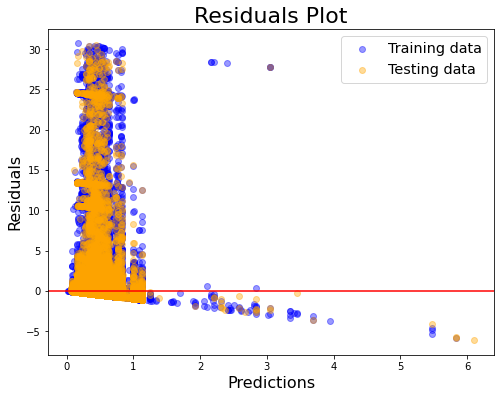

In [190]:
plt.figure(figsize=(8,6))
plt.title('Residuals Plot',size=22)
plt.xlabel('Predictions',size=16)
plt.ylabel('Residuals',size=16)
plt.axhline(0, c = "r")
plt.scatter(gamma_log_tr_preds, train_resids, label='Training data', alpha = .4,color='blue');
plt.scatter(gamma_log_te_preds, test_resids, label='Testing data',alpha = .4,color='orange');
plt.legend(loc='upper right',fontsize='x-large');

Looking at the residuals (errors) of our model, we see a large spike towards the left of the graph with a tail trailing to the right. This is unsurprising, as it resembles a Gamma distribution which is the type of regression that we used. As the values of predictions increased, the residuals were more consistently closer to zero, but also became more negative, showing the predictions became larger than the actual values. 

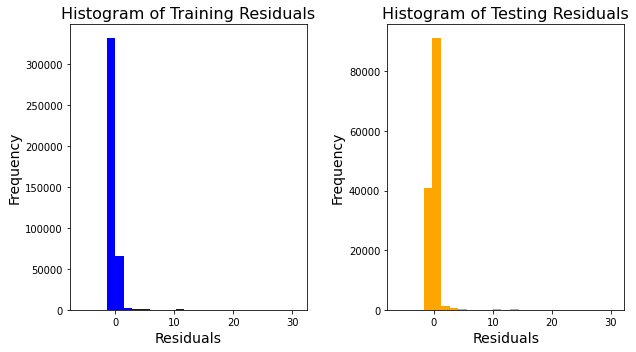

In [264]:
fig, axes = plt.subplots(figsize=(9,5), ncols=2)
axes[0].hist(train_resids,color='blue',bins=25)
axes[0].set_title('Histogram of Training Residuals',size=16)
axes[0].set_xlabel('Residuals', size=14)
axes[0].set_ylabel('Frequency',size=14)

axes[1].hist(test_resids,color='orange',bins=25)
axes[1].set_title('Histogram of Testing Residuals',size=16)
axes[1].set_xlabel('Residuals', size=14)
axes[1].set_ylabel('Frequency',size=14)

plt.tight_layout();

Again, the distributions of our residuals are following a Gamma distribution with a large spike on the left hand of the graph and a tail to the right. We can see this distribution in both the training and testing data. 

### Interpreting Coefficients
[Table of Contents](#Table-of-Contents)

In [624]:
# get p-values for all features
p_values = glm_gamma_log.pvalues
# get only significant features (p < .05)
sig_features = p_values[p_values < .05]
# get coefficients for significant features and exponentiate them 
coefs = [np.e ** glm_gamma_log.params[feature] for feature in sig_features.index]

In [625]:
feature_coefs = pd.DataFrame(index = sig_features.index, data={'Coefficient':coefs})

In [626]:
feature_coefs_cols = {
    'C(complaint_type)[T.Derelict Vehicle]' : 'Complaint Type: Derelict Vehicle',
    'C(borough)[T.BROOKLYN]' : 'Borough: Brooklyn',
    'C(borough)[T.MANHATTAN]' : 'Borough: Manhattan',
    'C(borough)[T.QUEENS]' : 'Borough: Queens',
    'C(borough)[T.STATEN ISLAND]' : 'Borough: Staten Island',
    'C(borough)[T.Unspecified]' : 'Borough: Unspecified',
    'C(open_data_channel_type)[T.PHONE]' : 'Open Data Channel Type: Phone',
    'C(cluster_predicted)[T.Noise Brooklyn]' : 'Cluster: Noise Brooklyn',
    'C(cluster_predicted)[T.Noise Queens]' : 'Cluster: Noise Queens',
    'C(cluster_predicted)[T.Parking Manhattan]' : 'Cluster: Parking Manhattan',
    'C(cluster_predicted)[T.Parking Queens]' : 'Cluster: Parking Queens'
}

# rename index to be human readable
feature_coefs.index = feature_coefs.index.map(feature_coefs_cols)

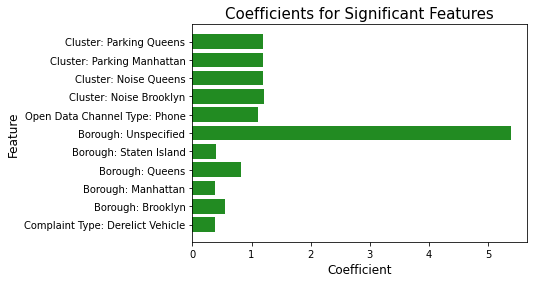

In [627]:
plt.barh(width = feature_coefs['Coefficient'], y = feature_coefs.index, color='forestgreen')
plt.title('Coefficients for Significant Features',size=15)
plt.ylabel('Feature',size=12)
plt.xlabel('Coefficient',size=12);

When looking at each of the features and their impact on the target variable, just a handful had a significant p-value of less than 0.05 indiciating influence on the target variable. All dummified columns related to the `borough` and  `cluster_predicted` features had significant p-values. Additionally, the `PHONE` option from `open_data_channel_type` and `Derelict Vehicle` from `complaint_type` showed significance as well. 

In the above graph, you can see the exponentiated coefficient for each of these significant features which can give insight into their impact on the target variable. 

From above we can see that the feature with the largest impact is _**Borough: Unspecified**_ which indicated a service request that was not labeled as occuring in any of the 5 boroughs. After further investigation, many of these requests had to do with bridges or highways. It is important to note that less than .1% of the data in the model had _**Unspecified**_ listed as its borough, which could have led to the inflated coefficient. 

It appears that each cluster had a similar impact on the target variable as their coefficients are very similar, all just above 1.

It is interesting to look at the remaining boroughs and the variation in their coefficient values. Queens had the largest coefficient value of the boroughs, while Manhatatan had the smallest, indicating that it would take more time to complete a request filed in Queens. 

In [278]:
feature_coefs.loc['Open Data Channel Type: Phone']

Coefficient    1.112973
Name: Open Data Channel Type: Phone, dtype: float64

If the service request was made by phone, it will take 1.1 times as much time to complete a 311 service request than those not submitted by phone, all else held constant. 

In [279]:
feature_coefs.loc['Borough: Manhattan']

Coefficient    0.378218
Name: Borough: Manhattan, dtype: float64

If the service request was for Manhattan, it will take .378 times as much time than requests submitted not from Manhattan, all other factors held constant. 

In [280]:
feature_coefs.loc['Borough: Queens']

Coefficient    0.821734
Name: Borough: Queens, dtype: float64

If the service request was for Queens, it will take .822 times as much time than requests submitted not from Queens, all other factors held constant. . 

### Evaluation Using Holdout Set
[Table of Contents](#Table-of-Contents)

Using our holdout set, we are seeing how our model would work on completely new and unseen data. This data was not used to help evaluate the intial performance of our model. 

In [284]:
X_holdout = val[features]
y_holdout = val['waittime']

In [285]:
# predicting k-modes clusters
val_clusters = km_cao.predict(X_holdout)

In [286]:
# setting up data frames to add predicted clusters from k-modes
val_ = val.copy().reset_index()
val_clusters_df = pd.DataFrame(val_clusters)
val_clusters_df.columns = ['cluster_predicted']

In [287]:
# creating new data frame with cluster predictions data
new_val = pd.concat([val_, val_clusters_df], axis=1).reset_index()
new_val.drop(columns=['level_0'],inplace=True)

In [288]:
# renaming 'cluster_predicted' values 
new_val['cluster_predicted'] = new_val['cluster_predicted'].map(cluster_names)

In [290]:
# setting up df for GLM
r_val = new_val[new_features + ['waittime']]

In [293]:
# predicting using Gamma GLM
gamma_val_preds = glm_gamma_log.predict(r_val)
print(f'RMSE:', rmse(y_holdout,gamma_val_preds))

RMSE: 3.665127856974558


The score for our validation set is much higher than that of our training sets. An RMSE of 3.67 days is more than double most of the training scores we saw earlier. It is important to note that in the training of our model, we limited our `waittime` variable at one month (31 days). That same limitation was not implemented here, so there are data that have wait times of much longer than that which the model has no experience predicting and thus is doing a worse job overall. 

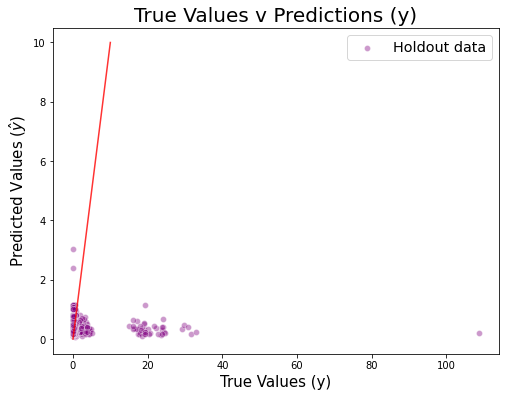

In [299]:
plt.figure(figsize=(8,6))
sns.scatterplot(y_holdout, gamma_val_preds, label='Holdout data',color='purple', alpha=.4)
plt.xlabel('True Values (y)',size=15)
plt.ylabel('Predicted Values ($\hat{y}$)',size=15)
plt.title('True Values v Predictions (y)',size=20)
plt.legend(loc='upper right',fontsize='x-large')

plt.plot((0,10),(0,10), c = "r", alpha = .8);

While there is much less data in our holdout set, you can still see that the predictions for this model are not accurate. As the true values increase, the predictions still remain between 0-2. There also is a definite outlier wait time of over 100 days, which is increasing the RMSE of this model.

In [309]:
val_resids = np.array(y_holdout) - np.array(gamma_val_preds)

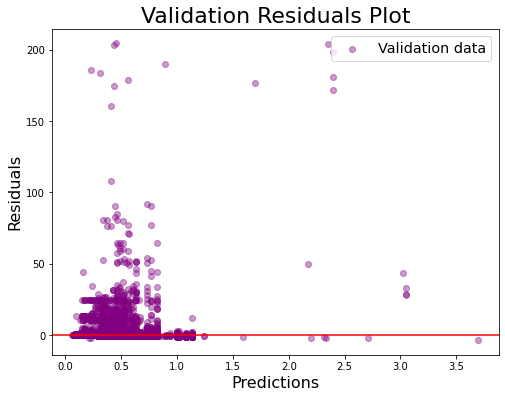

In [628]:
plt.figure(figsize=(8,6))
plt.title('Validation Residuals Plot',size=22)
plt.xlabel('Predictions',size=16)
plt.ylabel('Residuals',size=16)
plt.axhline(0, c = "r")
plt.scatter(gamma_val_preds, val_resids, label='Validation data', alpha = .4,color='purple');
plt.legend(loc='upper right',fontsize='x-large');

Again, our residuals display a lot of data towards the left end of the graph and a bit of a tail to the right. Additionally, on this residual graph, though, we see data in the upper right corner of the graph as well. These residuals roughly follow a Gamma distribution, but there are more inaccuracies in these predictions than in the original training data. 

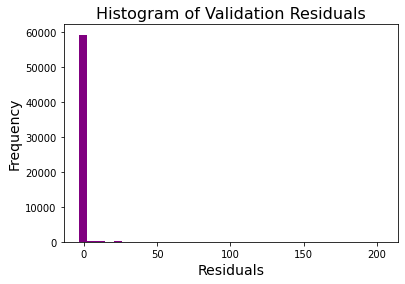

In [317]:
plt.hist(val_resids,color='purple',bins=35)
plt.title('Histogram of Validation Residuals',size=16)
plt.xlabel('Residuals', size=14)
plt.ylabel('Frequency',size=14);

The histogram of our validation residuals follow a Gamma distribution, similar to what we saw earlier and expect given the GLM we used.

## Pickling
[Table of Contents](#Table-of-Contents)

In order to build a website where civilians can input their service request and receive an estimation of how long until their request is resolved, we must pickle the models we use to make predictions. First, we will pickle the $k$-modes model in order to predict clusters, then we will pickle the GLM model. The pickled GLM model file is too large to push to GitHub so we will also pickle the AdaBoost model for convenience. 

In [556]:
# pickle k-modes
pickle.dump(km_cao, open('../models/km.p', 'wb'))

In [555]:
# pickle GLM Gamma

# check if output folder exists, if yes pass, if no, create folder
if os.path.exists('../bigmodels') == True:
    pass
else:
    os.mkdir('../bigmodels')

pickle.dump(glm_gamma_log, open('../bigmodels/model.p', 'wb'))

In [557]:
# pickle AdaBoost
pickle.dump(ada, open('../models/ada.p', 'wb'))

See README for further instructions for how to use the App for predicting 311 service requesst wait time.

## Conclusions & Recommendations
[Table of Contents](#Table-of-Contents)

Based on the performance of our models, it is clear that the features we looked at related to the context of the requests such as location, complaint type, and channel of request submission are not great predictors for how long it will take for a 311 service request to be resolved. The model that performed best took in only one feature and that was the date that the request was created. We cannot solely rely on that model because it looked at the average wait time by day and not individual requests as our other models did.

When we explored our GLM Gamma regression model more closely, it was found that the features which influenced wait time the most were those related to borough and cluster. Additionally, whether or not a submission was made via phone was significant as well. We saw the most variation of influence within the different boroughs. 

While location may be a possible indicator of wait time, using more specific location features than borough could lead to implicit associations with other factors such as race or socioeconomic status. 

Future projects would explore a time series model more deeply. A basic MA(1) model was a stronger predictor of wait time than our other regression models. By adding additional features to the time series model we could potentially improve the RMSE and overall performance of our model. 

The app could use improvements in performance, as location type should be specific for each complaint type as well, but is not currently set up that way. Therefore, submissions could be made that don't actually make sense such as a _**Noise - House of Worship**_ complaint occurring anywhere else besides a _House of Worship_. 

Next, we would look more deeply into some of the anomolies that occurred in the data. For example, we would explore any connections to the observations that had negative wait times, or outlier wait times of 200+ days. 

Being we did not anticipate to see negative wait times in our initial pull of the data, any request with a `created_date` that occurs after a `closed_date` has an incorrectly calculated wait time. In future iterations of this work we would correct that error. Being our model did not include observations with negative wait times, it did not affect the model itself. 

Lastly, we would extend this research to cover more types of service requests. We looked exclusively at those that are related to the NYPD agency. We would further improve our app by adding additional data from other agencies and service request types and either adding that to the current model, or making individual models for each agency. 

## References
[Table of Contents](#Table-of-Contents)

Ashish. “Bank Customer Clustering (K-Modes Clustering).” Kaggle, Kaggle, 15 Mar. 2019, 
	www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering.  
    
“Getting Started with NYC OpenData and the Socrata API.” Database and Programming Tutorials, 
	holowczak.com/getting-started-with-nyc-opendata-and-the-socrata-api/5/.  
    
Johnson, Jesse. “K-Modes.” The Shape of Data, 14 Sept. 2014, 
	shapeofdata.wordpress.com/2014/03/04/k-modes/.  
    
JSFiddle. JSFiddle, jsfiddle.net/7sntefum/.  
    
NYC OpenData. “311 Service Requests from 2010 to Present: NYC Open Data.” 311 Service Requests from 2010 to 
	Present | NYC Open Data, 7 June 2020, 
	data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9.  
    
NYC311. “About NYC311.” 311 Sets New Record with 44 Million Customer Interactions in 2018, 
	www1.nyc.gov/311/311-sets-new-record-in-2018.page.  
    
Shadkam-Farrokhi, Mahdi. “ARIMA Review.” GitHub Enterprise, 2020, 
	git.generalassemb.ly/DSI-US-11/local_arima.  
    
Shadkam-Farrokhi, Mahdi. “Using cross_val_score with a Custom Metric.” GitHub Enterprise, 2020, 
	git.generalassemb.ly/DSI-US-11/local_faq/blob/master/code/custom_cross_val_score.ipynb.  
    
“Socrata Developer Portal.” Socrata, dev.socrata.com/foundry/data.cityofnewyork.us/erm2-nwe9.  

Xmunoz. “Xmunoz/Sodapy.” GitHub, 2018, github.com/xmunoz/sodapy/blob/master/examples/soql_queries.ipynb.
